<a href="https://colab.research.google.com/github/meichenfang/Poisson-regression/blob/main/demos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparation

## Load packages

In [1]:
%cd ..

# Load before numpy to restrict its usage of cores, otherwise it will use all cores when doing @
import os
os.environ["BLAS_NUM_THREADS"] = "1" 
os.environ["OPENBLAS_NUM_THREADS"] = "1" # 

import Chronocell
print(Chronocell.__version__)

from Chronocell.inference import Trajectory
from Chronocell.mixtures import PoissonMixtureSS
from Chronocell.utils import *
from Chronocell.plotting import *

/home/mffang/workspace/Trajectory/FGP_2024
2024.10


In [2]:
import scipy.stats as stats
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
import anndata as ad
import scanpy as sc
import scvelo as scv
import copy
from multiprocessing import Pool
import cmasher as cmr
import pickle
import tqdm

Global seed set to 0


In [3]:
plt.rcParams['font.size'] = '24'
plt.rcParams['lines.linewidth'] = 6
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '36'
legend_font = '24'

## Load data

In [4]:
adata = ad.read("data/sim_demo.h5ad")
adata

AnnData object with n_obs × n_vars = 10000 × 200
    obs: 'time', 'celltype', 'read_depth'
    var: 'true_beta', 'true_gamma'
    varm: 'theta'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [5]:
true_theta = np.array(adata.varm["theta"])
rd = np.array(adata.obs["read_depth"])
r = rd/rd.mean()
true_t = np.array(adata.obs["time"])
N, p = adata.X.shape
X = np.zeros((N,p,2))
X[:,:,1] = adata.layers["spliced"]
X[:,:,0] = adata.layers["unspliced"]

## For R counts is gene by cell
counts = X[:,:,1].T

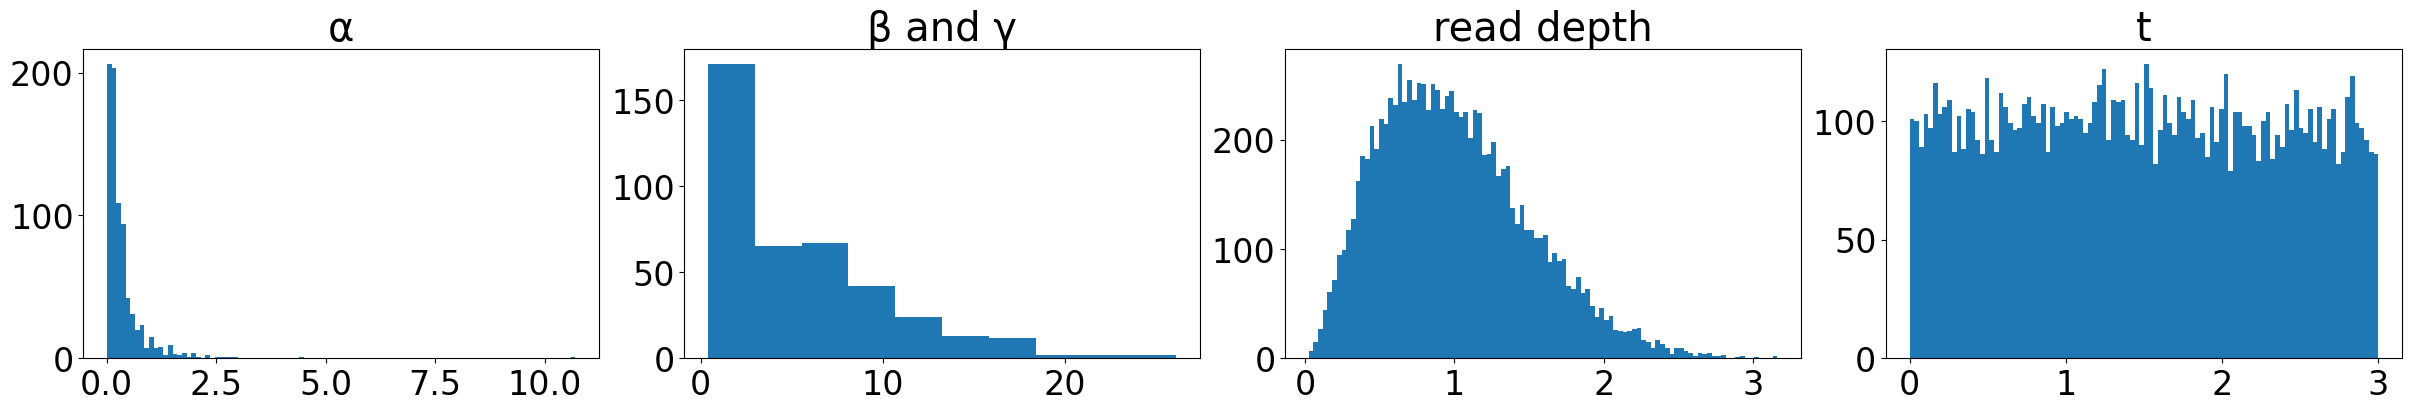

In [6]:
from Chronocell.models.two_species_ss import get_Y

def simulate_demo_data(topo, tau, n=1000, p=200, null_p=100, t_samples=None, loga_mu=2, loga_sd=1, logb_mu=2, logb_sd=0.5, rd_mu=0.25, rd_var=0.25, phi=0, random_seed=42, filepath=None, plot=True):    
    np.random.seed(random_seed)
    L=len(topo)
    K=len(tau)-1
    n_states=len(set(topo.flatten()))
    
    theta=np.zeros((p,n_states+2))
    theta[:,:n_states]=np.random.lognormal(loga_mu,loga_sd,size=(p,n_states))
    theta[:,-2:]=np.random.lognormal(logb_mu,logb_sd,size=(p,2))
    theta[:,:n_states]/=theta[:,-2,None]
    theta[:,-1]/=np.exp(1.5)
    theta[-null_p:,:n_states]=theta[-null_p:,0,None]
    
    true_t = []
    Y = np.zeros((n*L,p,2))
    for l in range(L):
        theta_l = np.concatenate((theta[:,topo[l]], theta[:,-2:]), axis=1)
        t = np.sort(np.random.uniform(tau[0],tau[-1],size=n))
        Y[l*n:(l+1)*n] = get_Y(theta_l,t,tau) # m*p*2
        true_t = np.append(true_t,t)

    if rd_var != 0:
        a = (1-rd_mu)/rd_var - rd_mu
        b = (1/rd_mu-1)*a
        read_depth = np.random.beta(a=a, b=b, size=n*L)             
    else:
        read_depth = np.ones(n*L) * rd_mu
        
    theta[:,:n_states] *= rd_mu 
    Z = read_depth[:,None,None]*Y
    
    if phi > 0:
        Z *= np.random.gamma(shape=1/phi,scale=phi,size=(n*L,p,2))
    X = np.random.poisson(Z)
    
    if plot:
        fig, ax = plt.subplots(1,4,figsize=(24,4))
        ax[0].hist(theta[:,:-2].flatten(),bins=100)
        ax[0].set_title("α")
        ax[1].hist(theta[:,-2:].flatten(),bins=10)
        ax[1].set_title("β and γ")
        ax[2].hist(read_depth/read_depth.mean(),bins=100)
        ax[2].set_title("read depth")
        ax[3].hist(true_t,bins=100)
        ax[3].set_title("t")
    
    if filepath is not None:
        adata=ad.AnnData(np.sum(X,axis=-1),dtype=X.dtype)
        adata.layers["spliced"] = X[:,:,1]
        adata.layers["unspliced"] = X[:,:,0]
        adata.layers["ambiguous"]=np.zeros_like(X[:,:,0])
        adata.obs["time"]=true_t
        adata.obs["celltype"]=topo[(np.arange(n*L)//n),np.array(true_t*K/tau[-1],dtype=int)]
        adata.obs["read_depth"]=read_depth
        adata.varm["theta"]=theta
        adata.var["true_beta"]=theta[:,-2]
        adata.var["true_gamma"]=theta[:,-1]
        adata.write(filepath)
        
    return theta, true_t, rd_mu*Y, X, read_depth
    
true_topo=np.array([[0,1,2],[0,1,3]])
true_tau = (0,2,3)
topo=np.array([[0,1,2,3],[0,1,2,4]])
tau=(0,1.,2.,3.)
L=len(topo)
n=5000
true_theta, true_t, Y, X, rd = simulate_demo_data(true_topo, true_tau, n=n, random_seed=42, filepath=None)

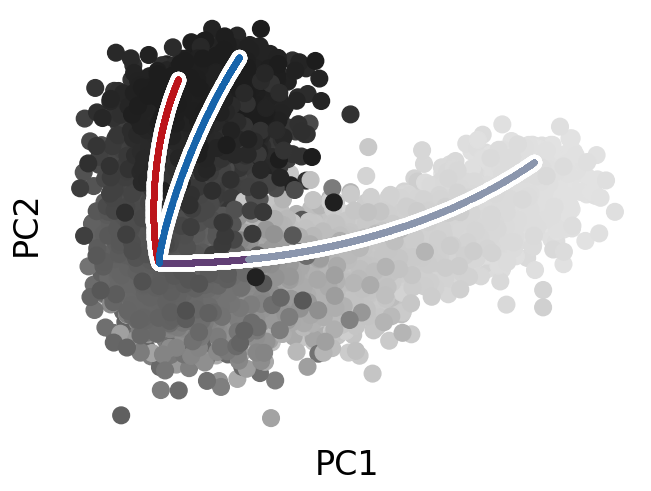

In [7]:
x = X[:,:,1]
y = Y[:,:,1]
n = len(x)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(np.log1p(x/r[:,None]))
Y_pca = pca.transform(np.log1p(y))

light_purple = cmr.get_sub_cmap('Purples', 0., 1)(0.25)
purple = '#613f75'
blue = cmr.get_sub_cmap('Blues', 0., 1)(0.8)
red = cmr.get_sub_cmap('Reds', 0., 1)(0.8)

cmap_t = cmr.get_sub_cmap('Greys', 0.2, 0.9)
fig, ax = plt.subplots(1,1)
ax.scatter(X_pca[:,0],X_pca[:,1],c=true_t,cmap=cmap_t);

ax.scatter(Y_pca[(true_t > 1)&(true_t <= 2),0],Y_pca[(true_t > 1)&(true_t <= 2),1],s=100,color='w');
ax.scatter(Y_pca[(true_t>2) & (np.arange(n)>=n//L),0],Y_pca[(true_t>2) & (np.arange(n)>=n//L),1],s=100,color='w');
ax.scatter(Y_pca[(true_t>2) & (np.arange(n)<n//L),0],Y_pca[(true_t>2) & (np.arange(n)<n//L),1],s=100,color='w');
ax.scatter(Y_pca[(true_t<1) ,0],Y_pca[(true_t<1) ,1],s=100,color='w');

ax.scatter(Y_pca[(true_t > 1)&(true_t <= 2),0],Y_pca[(true_t > 1)&(true_t <= 2),1],s=10,color=purple);
ax.scatter(Y_pca[(true_t>2) & (np.arange(n)>=n//L),0],Y_pca[(true_t>2) & (np.arange(n)>=n//L),1],s=10,color=red);
ax.scatter(Y_pca[(true_t>2) & (np.arange(n)<n//L),0],Y_pca[(true_t>2) & (np.arange(n)<n//L),1],s=10,color=blue);
ax.scatter(Y_pca[true_t <= 1,0],Y_pca[(true_t <= 1),1],s=10,color='#8b96ad');
ax.set_xlabel('PC1',fontsize=24)
ax.set_ylabel('PC2',fontsize=24)
ax.set_frame_on(False)
plt.xticks([]);
plt.yticks([]);

# Slingshot + tradeSeq
We follow the step in https://bioconductor.org/packages/devel/bioc/vignettes/slingshot/inst/doc/vignette.html

In [8]:
import rpy2
import rpy2.robjects as robjects

In [9]:
%load_ext rpy2.ipython

In [10]:
%%R 

library(tradeSeq, quietly = TRUE)
library(RColorBrewer, quietly = TRUE)
library(SingleCellExperiment, quietly = TRUE)
library(slingshot, quietly = TRUE)
library(umap, quietly = TRUE)
library(scran, quietly = TRUE)
library(scater, quietly = TRUE)
library(scuttle, quietly = TRUE)
library(Seurat, quietly = TRUE)
library(mclust, quietly = TRUE)

R[write to console]: 
Attaching package: ‘MatrixGenerics’


R[write to console]: The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDiffs, rowSds, rowSums2, rowTabulates, rowVarDiffs, rowVars,
    r


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: 
Attaching package: ‘scran’


R[write to console]: The following object is masked from ‘package:TrajectoryUtils’:

    createClusterMST


R[write to console]: Attaching SeuratObject

R[write to console]: ‘SeuratObject’ was built under R 4.3.1 but the current version is
4.3.3; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed

R[write to console]: Seurat v4 was just loaded with SeuratObject v5; disabling v5 assays and
validation routines, and ensuring assays work in strict v3/v4
compatibility mode

R[write to console]: 
Attaching package: ‘Seurat’


R[write to console]: The following object is masked from ‘package:SummarizedExperiment’:

    Assays


R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



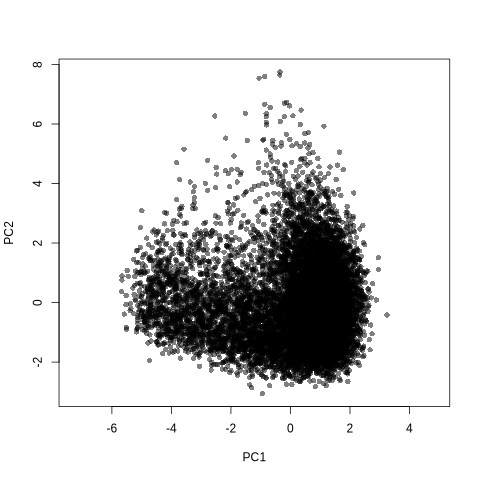

In [11]:
%%R -i counts

set.seed(42)
sce <- SingleCellExperiment(assays = list(counts = counts))
geneFilter <- apply(assays(sce)$counts,1,function(x){
    sum(x >= 3) >= 10
})
sce <- sce[geneFilter, ]

FQnorm <- function(counts){
    rk <- apply(counts,2,rank,ties.method='min')
    counts.sort <- apply(counts,2,sort)
    refdist <- apply(counts.sort,1,median)
    norm <- apply(rk,2,function(r){ refdist[r] })
    rownames(norm) <- rownames(counts)
    return(norm)
}
assays(sce)$norm <- FQnorm(assays(sce)$counts)

pca <- prcomp(t(log1p(assays(sce)$norm)), scale. = FALSE)
rd1 <- pca$x[,1:2]
reducedDims(sce) <- SimpleList(PCA = rd1)
plot(rd1, col = rgb(0,0,0,.5), pch=16, asp = 1)

fitting ...
  |======================================================================| 100%


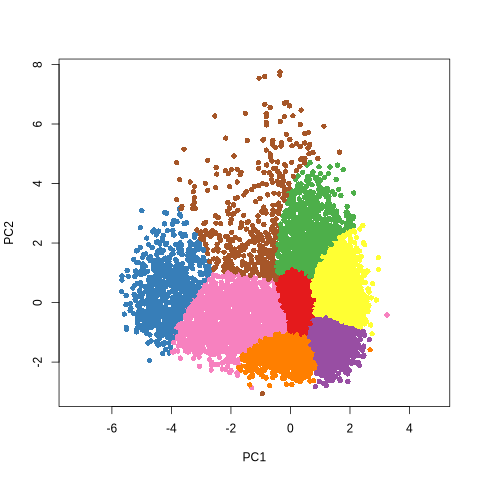

In [12]:
%%R
cl1 <- Mclust(rd1)$classification
colData(sce)$GMM <- cl1

library(RColorBrewer)
plot(rd1, col = brewer.pal(9,"Set1")[cl1], pch=16, asp = 1)

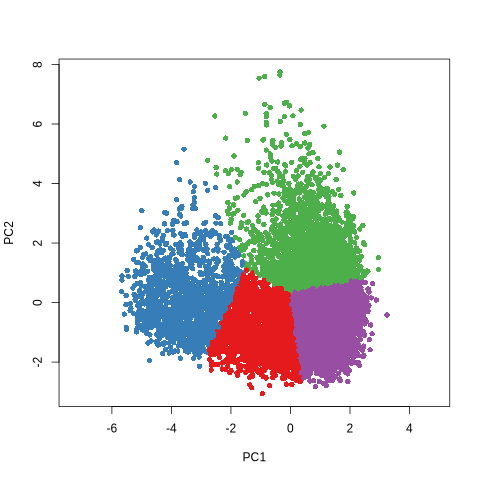

In [13]:
%%R
cl2 <- kmeans(rd1, centers = 4)$cluster
colData(sce)$kmeans <- cl2

plot(rd1, col = brewer.pal(9,"Set1")[cl2], pch=16, asp = 1)

## Set1: red blue green purple

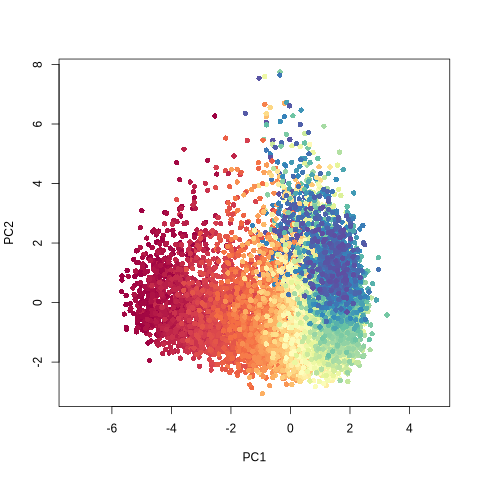

In [14]:
%%R -i true_t
# Create a continuous color ramp from the Spectral colormap
color_ramp <- colorRampPalette(brewer.pal(11, "Spectral"))

# Normalize true_t (or C) to [0, 1]
norm_true_t <- (true_t - min(true_t)) / (max(true_t) - min(true_t))

# Create a palette of 100 colors from the Spectral colormap
colors <- color_ramp(100)

# Map normalized true_t to the color palette using cut()
mapped_colors <- colors[cut(norm_true_t, breaks = 100)]

# Plot the reduced dimensions (rd) with colors based on continuous true_t
plot(rd1, col = mapped_colors, pch = 16, asp = 1)

In [15]:
%%R
# slingshot with the true start cluster provided
sce <- slingshot(sce, clusterLabels = 'kmeans', reducedDim = 'PCA', start.clus = 2)
colData(sce)$slingshot

class: PseudotimeOrdering 
dim: 10000 1 
metadata(4): lineages mst slingParams curves
pathStats(2): pseudotime weights
cellnames(10000): Cell-1 Cell-2 ... Cell-9999 Cell-10000
cellData names(2): reducedDim clusterLabels
pathnames(1): Lineage1
pathData names(0):


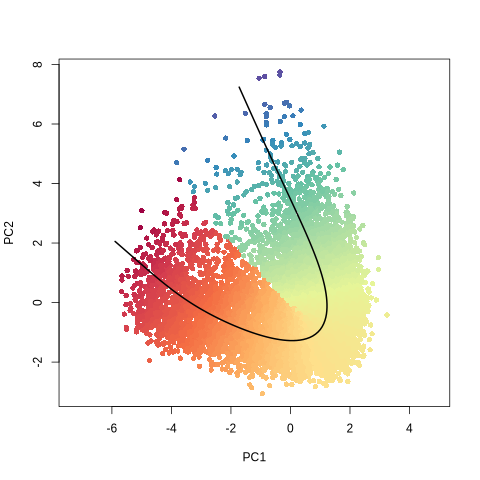

In [16]:
%%R
library(grDevices)
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plotcol <- colors[cut(sce$slingPseudotime_1, breaks=100)]

plot(reducedDims(sce)$PCA, col = plotcol, pch=16, asp = 1)
lines(SlingshotDataSet(sce), lwd=2, col='black')

In [17]:
%%R

#pdf('principle_curve.pdf')
par(mar = c(4, 6, 0, 0))

weights = slingCurveWeights(sce)
weight = weights/rowSums(weights)
time1 = sce$slingPseudotime_1
time1[is.na(time1)] = 0
x_pca = reducedDims(sce)$PCA

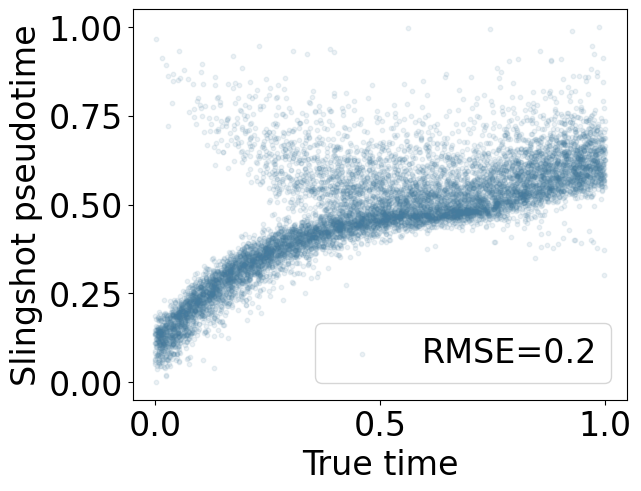

In [18]:
time1 = robjects.r['time1']

t = time1/np.max(time1)
rmse = np.sqrt(np.mean((norm(true_t)-norm(t))**2))

plt.scatter(norm(true_t),norm(t),s=10,color='#457b9d',alpha=0.1,label='RMSE='+str(np.around(rmse,2)))
plt.xlabel('True time')
plt.ylabel('Slingshot pseudotime')
plt.legend()

# DPT

We follow this [tutorial](https://scanpy.readthedocs.io/en/stable/tutorials/trajectories/paga-paul15.html)

In [20]:
data = sc.read('data/sim_demo.h5ad')
data

AnnData object with n_obs × n_vars = 10000 × 200
    obs: 'time', 'celltype', 'read_depth'
    var: 'true_beta', 'true_gamma'
    varm: 'theta'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [21]:
sc.pp.recipe_zheng17(data, n_top_genes=200)
sc.tl.pca(data, svd_solver="arpack")

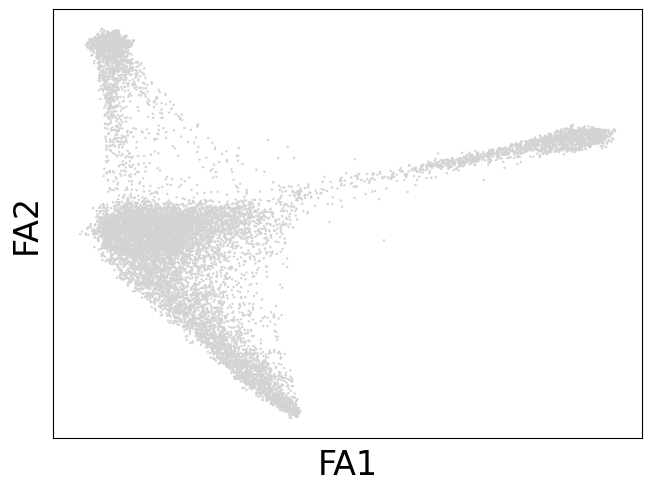

In [24]:
sc.pp.neighbors(data, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(data)

sc.tl.diffmap(data)
sc.pp.neighbors(data, n_neighbors=10, use_rep="X_diffmap")
sc.pl.draw_graph(data, legend_loc="on data")

In [25]:
sc.tl.leiden(data)
sc.tl.paga(data, groups="leiden")

In [26]:
data.uns["iroot"] = 0
sc.tl.dpt(data)

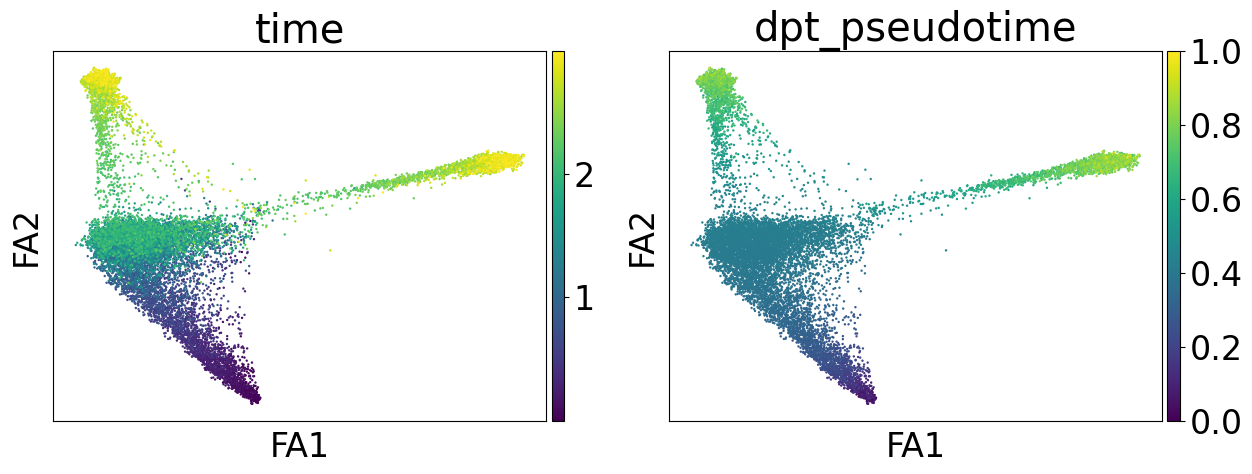

In [27]:
sc.pl.draw_graph(data, color=["time", "dpt_pseudotime"], legend_loc="on data")

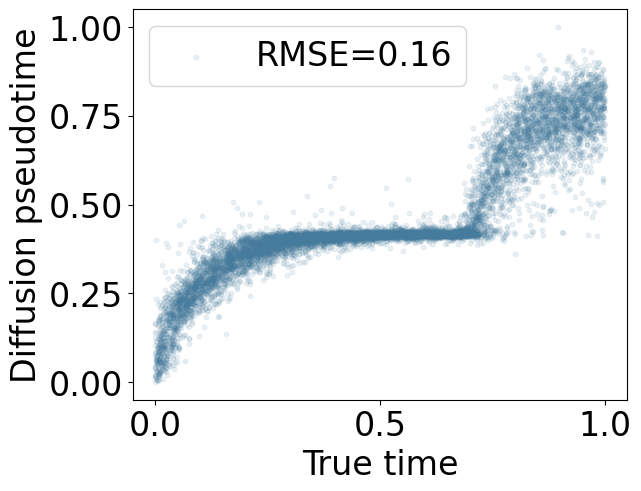

In [28]:
# Extract pseudotime
t = data.obs["dpt_pseudotime"]

# Remove NaN values
mask = ~np.isnan(t) & ~np.isinf(t)  # Mask to ignore NaNs in both true_t and t
filtered_t = t[mask]
filtered_true_t = true_t[mask]/3

# Calculate RMSE
rmse = np.sqrt(np.mean((norm(filtered_true_t) - norm(filtered_t)) ** 2))

# Plot the results
plt.scatter(filtered_true_t, filtered_t, s=10,color='#457b9d',alpha=0.1,label='RMSE='+str(np.around(rmse,2)))
plt.xlabel('True time')
plt.ylabel('Diffusion pseudotime')
plt.legend()
plt.show()

# VeloVI

https://velovi.readthedocs.io/en/latest/tutorial.html

In [29]:
import scanpy as sc
import scvelo as scv
import torch
from velovi import preprocess_data, VELOVI

import seaborn as sns

torch.set_num_threads(10)

In [30]:
adata = sc.read('data/sim_demo.h5ad')
scv.pp.filter_and_normalize(adata, min_shared_counts=30)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

Filtered out 1 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.


/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


computing neighbors
    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [31]:
adata = preprocess_data(adata)

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [32]:
sc.tl.umap(adata)

In [33]:
VELOVI.setup_anndata(adata, spliced_layer="Ms", unspliced_layer="Mu")
vae = VELOVI(adata)
vae.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 351/500:  70%|███████   | 351/500 [13:09<05:35,  2.25s/it, loss=-67.5, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -67.448. Signaling Trainer to stop.


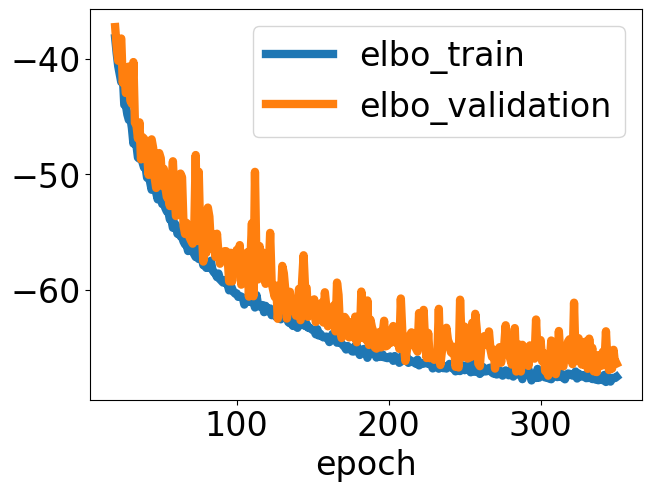

In [34]:
fig, ax = plt.subplots()
vae.history["elbo_train"].iloc[20:].plot(ax=ax, label="train")
vae.history["elbo_validation"].iloc[20:].plot(ax=ax, label="validation")
plt.legend()

In [35]:
def add_velovi_outputs_to_adata(adata, vae):
    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    adata.layers["velocity"] = velocities / scaling
    adata.layers["latent_time_velovi"] = latent_time

    adata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    adata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    adata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    adata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    adata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    adata.var['fit_scaling'] = 1.0

add_velovi_outputs_to_adata(adata, vae)

In [36]:
latent_time = vae.get_latent_time(n_samples=25)
np.shape(latent_time)

(10000, 67)

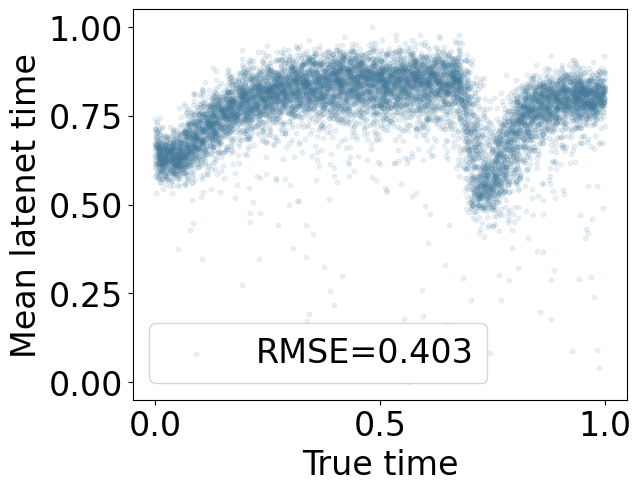

In [38]:
# Extract pseudotime
t = adata.layers["latent_time_velovi"].mean(1)
true_t = adata.obs["time"]

# Remove NaN values
mask = ~np.isnan(t) & ~np.isinf(t)  # Mask to ignore NaNs in both true_t and t
filtered_t = norm(t[mask])
filtered_true_t = norm(true_t[mask])

# Calculate RMSE
rmse = np.sqrt(np.mean((filtered_true_t - filtered_t) ** 2))

# Plot the results
plt.scatter(filtered_true_t, filtered_t, s=10, color='#457b9d', alpha=0.1, label='RMSE=' + str(np.around(rmse, 3)))
plt.xlabel('True time')
plt.ylabel('Mean latenet time')
plt.legend()
plt.show()

In [39]:
scv.tl.velocity_graph(adata)

computing velocity graph (using 1/88 cores)


  0%|          | 0/10000 [00:00<?, ?cells/s]

    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


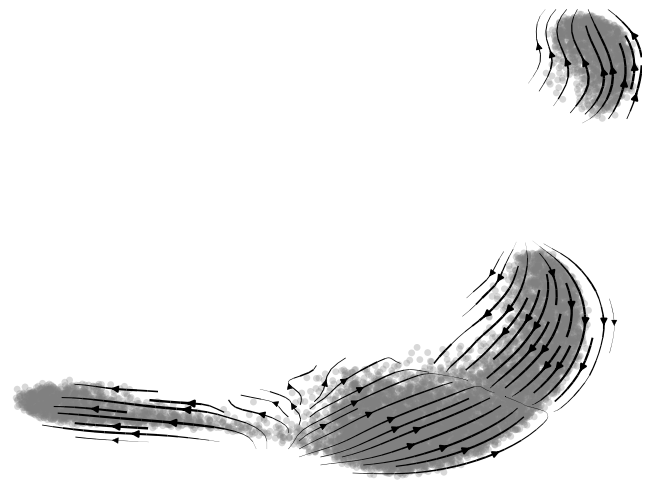

In [40]:
scv.pl.velocity_embedding_stream(adata, basis='umap')

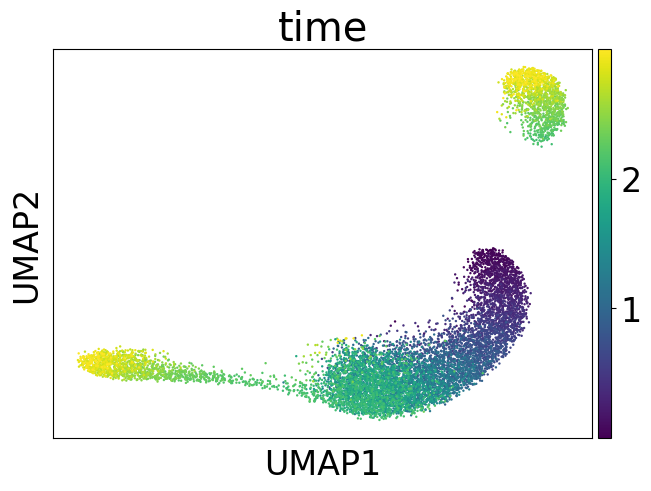

In [41]:
sc.pl.umap(adata,color=['time'])